In [37]:
import json
from os import listdir
from os.path import join
import pandas as pd
import networkx as nx

from typing import List

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [38]:
def load_json_dir (directory: str) -> List[dict]: 
    '''
    Load each file in a directory of JSON files
    '''
    filenames = listdir(directory)
    def load_by_fn (fn: str) -> dict:
        return json.load(open(join(directory, fn)))
    lst = [load_by_fn(f) for f in filenames if f != 'search.json']
    return [l for l in lst if 'is_planned' in l] # some items aren't cables. use presence of `is_planned` key to determine whether item is a cable

In [39]:
cables = load_json_dir('www.submarinecablemap.com/web/public/api/v3/cable/')

# Make a graph for the whole world

In [40]:
from pycountry_convert import country_name_to_country_alpha2

In [41]:
def cc2_of (landing_point):
    country_name = landing_point['country']
    # special cases
    if country_name == "Virgin Islands (U.K.)":
        return 'GB'
    if country_name == "Virgin Islands (U.S.)":
        return 'US'
    if country_name == "Sint Maarten":
        return 'NL'
    if country_name == "Congo, Dem. Rep.":
        return 'CD'
    if country_name == "Congo, Rep.":
        return 'CG'
    if country_name == 'Netherlands Antilles':
        return 'NL'
    return country_name_to_country_alpha2(country_name)

lp = cables[0]['landing_points'][0]
cc2_of(lp)

'ID'

In [42]:
from itertools import combinations

def add_to_edges_dict (a, b, edges_dict):
    #  sort tuple
    # this assures there's one entry per pair of countries
    dict_key = tuple(sorted((a, b,), key=lambda tup: tup[1]))
    # side-effectily mutate edges_dict
    # TODO refactor to get rid of mutation
    if dict_key in edges_dict:
        edges_dict[dict_key] = edges_dict[dict_key]+1
    else:
        edges_dict[dict_key] = 1
        
def assemble_edges (ignore_future_cables=True):
    edges = {}
    for cable in cables:
        if ignore_future_cables and cable['is_planned']:
#             print('ignoring future cable')
            continue
        connections = [cc2_of(lp) for lp in cable['landing_points']]
        pairs = combinations(set(connections), 2)
        print(list(pairs))
        for pair in pairs:
            a, b = pair
            print(a, b)
            add_to_edges_dict(a, b, edges)
    return edges

edges_today = assemble_edges()

[]
[]
[('AU', 'US'), ('AU', 'FJ'), ('AU', 'NZ'), ('US', 'FJ'), ('US', 'NZ'), ('FJ', 'NZ')]
[]
[('JP', 'PH'), ('JP', 'CN'), ('JP', 'MY'), ('JP', 'SG'), ('PH', 'CN'), ('PH', 'MY'), ('PH', 'SG'), ('CN', 'MY'), ('CN', 'SG'), ('MY', 'SG')]
[('GB', 'ES'), ('GB', 'PT'), ('ES', 'PT')]
[]
[('IN', 'SG')]
[('BN', 'VN'), ('BN', 'US'), ('BN', 'TH'), ('BN', 'PH'), ('BN', 'CN'), ('BN', 'MY'), ('BN', 'SG'), ('VN', 'US'), ('VN', 'TH'), ('VN', 'PH'), ('VN', 'CN'), ('VN', 'MY'), ('VN', 'SG'), ('US', 'TH'), ('US', 'PH'), ('US', 'CN'), ('US', 'MY'), ('US', 'SG'), ('TH', 'PH'), ('TH', 'CN'), ('TH', 'MY'), ('TH', 'SG'), ('PH', 'CN'), ('PH', 'MY'), ('PH', 'SG'), ('CN', 'MY'), ('CN', 'SG'), ('MY', 'SG')]
[('PK', 'AE'), ('PK', 'LK'), ('PK', 'IT'), ('PK', 'FR'), ('PK', 'TH'), ('PK', 'DZ'), ('PK', 'BD'), ('PK', 'TN'), ('PK', 'SA'), ('PK', 'IN'), ('PK', 'EG'), ('PK', 'MY'), ('PK', 'SG'), ('AE', 'LK'), ('AE', 'IT'), ('AE', 'FR'), ('AE', 'TH'), ('AE', 'DZ'), ('AE', 'BD'), ('AE', 'TN'), ('AE', 'SA'), ('AE', 'IN'), ('

In [74]:
edges = {}

def construct_graph (**kwargs):
    G = nx.Graph()
    edges = assemble_edges(**kwargs)
    nodes = set(flatten(edges.keys()))
    for node in nodes:
        G.add_node(node)
    for edge, weight in edges.items():
        a, b = edge
        G.add_edge(a, b, weight=weight)
        
    return G

G = construct_graph()

In [75]:
future_G = construct_graph(ignore_future_cables=False)

In [76]:
nx.write_gpickle(G, 'undersea_today.networkx')
nx.write_gpickle(future_G, 'undersea_future.networkx')

# Analyze the graph of the world

https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python#the-shape-of-the-network

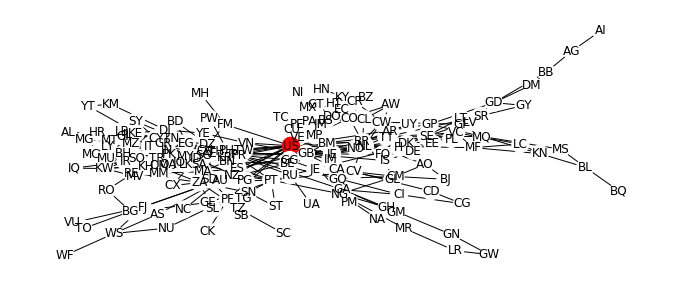

In [77]:
def plot_net (graph):
    color_map = []
    for node in graph:
        if node == 'US':
            color_map.append('red')
        else: 
            color_map.append('white')      
            
    fig, ax = plt.subplots(1, 1, figsize=(12, 5));
    nx.draw(graph, node_color=color_map, with_labels=True)
    plt.show()
    
plot_net(G) 

# Network density

In [78]:
density = nx.density(G)
density

0.027313381492948055

## Diameter (of largest subgraph)

In [79]:
# Next, use nx.connected_components to get the list of components,
# then use the max() command to find the largest one:
components = nx.connected_components(G)
largest_component = max(components, key=len)

# Create a "subgraph" of just the largest component
# Then calculate the diameter of the subgraph, just like you did with density.
#

subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
diameter

10

# Plot of largest subgraph

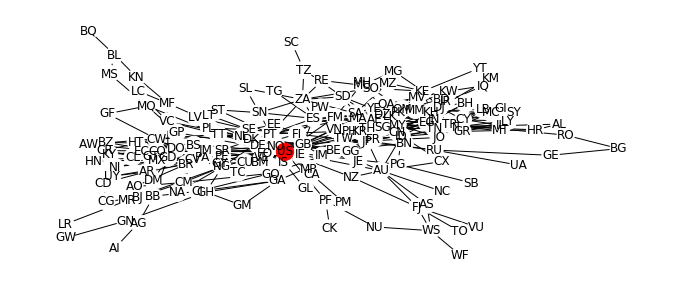

In [80]:
plot_net(subgraph)

## Clustering coefficient
Transitivity is the ratio of all triangles over all possible triangles. A possible triangle exists when one person (Fox) knows two people (Fell and Whitehead). So transitivity, like density, expresses how interconnected a graph is in terms of a ratio of actual over possible connections. 

In [81]:
nx.transitivity(G)

0.2

## Degree centrality

In [82]:
from operator import itemgetter

In [83]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

In [84]:
def top_n (my_dict, n, reverse=True):
    sorted_dict = sorted(my_dict.items(), key=itemgetter(1), reverse=reverse)
    return sorted_dict[:n]

In [85]:
top_degree = top_n(degree_dict, 20)

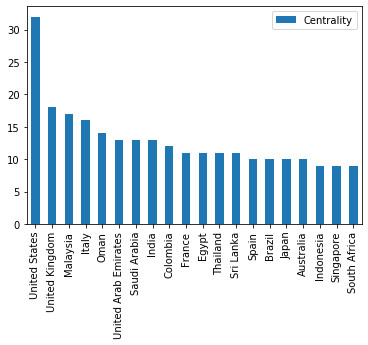

In [87]:
from pycountry_convert import country_alpha2_to_country_name   
def plot_top (top_lst, title='Centrality', **kwargs):
    degree = pd.DataFrame(top_lst, columns=['Country', title])
    degree.index = degree['Country']
    degree['Country'] = degree['Country'].apply(country_alpha2_to_country_name)
    ax = degree.plot.bar(**kwargs)
    ax.set_xlabel('')
    return ax
    
plot_top(top_degree)

## Betweeness centrality

In [88]:
# from jupyterthemes import jtplot

# # scale font-size of ticklabels, legend, etc.
# # remove spines from x and y axes and make grid dashed
# jtplot.style(context='talk', fscale=1, spines=False, gridlines='--')

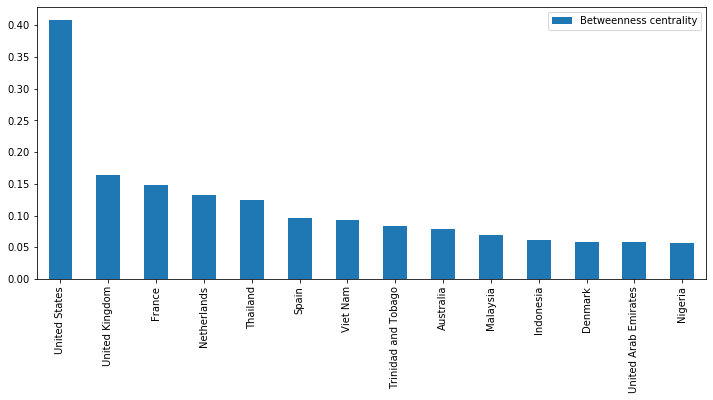

In [89]:
betweenness_dict = nx.betweenness_centrality(G, weight='weight') # Run betweenness centrality
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
ax = plot_top(top_n(betweenness_dict, 14), title='Betweenness centrality', figsize=(12, 5))

In [90]:
top_n(betweenness_dict, 1)

[('US', 0.4083160283234509)]

#### Compare to future graph!
will US's power increase/decrease in the future?

In [91]:
future_betweenness_dict = nx.betweenness_centrality(future_G) # Run betweenness centrality
nx.set_node_attributes(future_G, future_betweenness_dict, 'betweenness')
top_n(future_betweenness_dict, 1)

[('US', 0.42309691679805067)]

In [29]:
def change_in_future (cc2):
    return (future_betweenness_dict[cc2] - betweenness_dict[cc2])/ betweenness_dict[cc2]

In [30]:
change_in_future('US')

0.045629243433024165

In [31]:
change_in_future('CN')

-0.15233532578617476

## Eigenvector centrality

<AxesSubplot:>

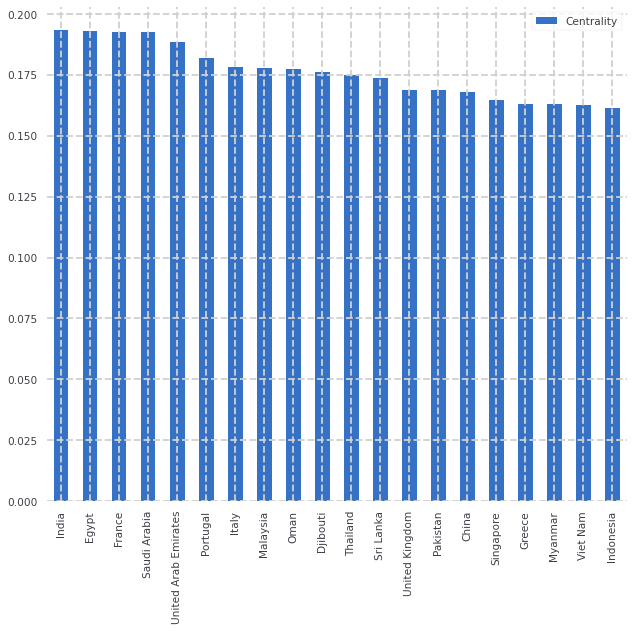

In [32]:
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')
plot_top(top_n(eigenvector_dict, 20))

## Community detection

In [33]:
import community

In [34]:
communities = community.best_partition(G)
nx.set_node_attributes(G, communities, 'modularity')

In [35]:
G.nodes['US']

{'degree': 70,
 'betweenness': 0.40958780793642824,
 'eigenvector': 0.08450398863284823,
 'modularity': 5}

In [36]:
def eigenvector_in_class (class_n, top=3):
    # First get a list of just the nodes in that class
    class0 = [n for n in G.nodes() if G.nodes[n]['modularity'] == class_n]
    # Then create a dictionary of the eigenvector centralities of those nodes
    class0_eigenvector = {n:G.nodes[n]['eigenvector'] for n in class0}
    # Then sort that dictionary and print the first 5 results
    class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)
    return class0_sorted_by_eigenvector[:top]

eigenvector_in_class(4)

[('TM', 1.260044883752411e-30)]

In [37]:
communities_dict = {}
for node, group in communities.items():
    if group not in communities_dict:
        communities_dict[group] = [ node ]
    if group in communities_dict:
        member_lst = communities_dict[group]
        member_lst.append(node)
        communities_dict[group] = member_lst
communities_dict

{0: ['AZ', 'AZ'],
 1: ['PM',
  'PM',
  'NO',
  'BG',
  'IE',
  'CA',
  'EE',
  'IS',
  'RU',
  'DK',
  'GE',
  'RO',
  'IM',
  'GL',
  'DE',
  'NL',
  'SE',
  'FI',
  'UA',
  'FO',
  'LV',
  'PL',
  'LT'],
 2: ['MF',
  'MF',
  'VC',
  'BB',
  'BQ',
  'AI',
  'GD',
  'TT',
  'MQ',
  'MS',
  'AG',
  'DM',
  'SX',
  'VG',
  'BL',
  'KN',
  'GP',
  'LC',
  'GY',
  'SR'],
 3: ['MG',
  'MG',
  'BN',
  'GI',
  'MM',
  'IL',
  'DZ',
  'KR',
  'FR',
  'HR',
  'SA',
  'SG',
  'JE',
  'QA',
  'VN',
  'AE',
  'SC',
  'TN',
  'KH',
  'MA',
  'SY',
  'OM',
  'AL',
  'BE',
  'PK',
  'GG',
  'DJ',
  'JO',
  'BD',
  'CY',
  'YT',
  'TZ',
  'GR',
  'SO',
  'CX',
  'TW',
  'PH',
  'SD',
  'ID',
  'MU',
  'NC',
  'JP',
  'YE',
  'IT',
  'BH',
  'MZ',
  'LK',
  'IN',
  'GB',
  'EG',
  'LY',
  'KW',
  'IQ',
  'MY',
  'MV',
  'RE',
  'IR',
  'CN',
  'LB',
  'KM',
  'MC',
  'KE',
  'TR',
  'TH',
  'AU',
  'MT'],
 4: ['TM', 'TM'],
 5: ['GF',
  'GF',
  'CW',
  'BR',
  'DO',
  'MH',
  'VE',
  'BZ',
  'CO',
  'BS

# Who is most vulnerable to cable cutting?

## Who is only connected to one other node?

In [38]:
lowest_degree = top_n(degree_dict, 30, reverse=False)
for cc2, degree in lowest_degree:
    if degree==1:
        from_country = cc_to_country(cc2)
        edges = G.edges(cc2)
        for edge in edges:
            print(from_country, 'only connects to', cc_to_country(edge[1]))

Saint Pierre and Miquelon only connects to Canada
Seychelles only connects to Tanzania, United Republic of
Tonga only connects to Fiji
New Caledonia only connects to Australia
Northern Mariana Islands only connects to United States
Vanuatu only connects to Fiji
Netherlands Antilles only connects to Curacao
Ukraine only connects to Russian Federation
Malta only connects to Italy


In [39]:
betweenness_dict.values()

dict_values([0.0, 0.0, 0.003417484909197599, 0.00040272802703741927, 0.0, 0.006925934633043288, 0.0, 0.0, 0.0006747957010827281, 0.0006740736005211553, 0.0, 0.012929535669553661, 0.035783025313564316, 0.0, 7.358790886402088e-05, 0.005888737158914424, 0.00762657769101105, 0.07314132678960975, 0.0, 0.0032870235848090667, 0.0, 0.0041191043451388794, 0.0, 0.021542586676082602, 0.0, 0.013869881071773933, 0.0, 0.00013818169857701286, 0.001730812096925948, 0.009605060853859215, 0.014381230044234469, 0.0, 0.0, 0.006357786380922379, 0.0022379159908757383, 0.0, 0.0017892034263217154, 0.002242630705814467, 0.0, 0.018695943448054805, 0.0, 0.006357786380922379, 0.0, 0.0, 0.0048223001561957385, 0.00284936693939131, 0.0, 0.0, 0.012322795734416591, 0.0, 0.00219617468605472, 0.0017324094232734494, 0.0, 0.028620305249498008, 0.0019027606792823377, 0.0, 0.0, 0.00010832830537338378, 0.012892850345750812, 0.006974762155050149, 0.0, 0.010735970891414493, 0.0, 0.012586531345506151, 0.0035515275760539416, 9.8

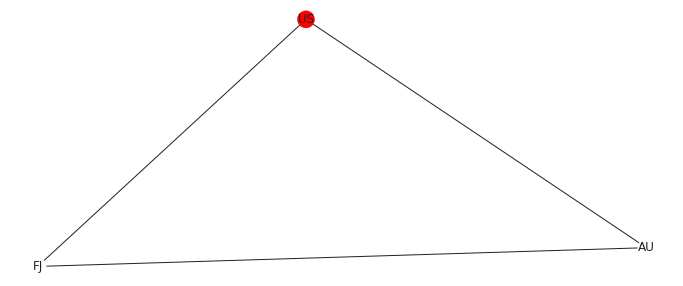

In [40]:
plot_net(G.subgraph(['AU', 'FJ', 'US']))

In [41]:
G.nodes['CU']

{'degree': 3,
 'betweenness': 0.0,
 'eigenvector': 0.0029202858385364073,
 'modularity': 5}

In [44]:
nx.node_connected_component(G, 'CU')
